# Imports

In [ ]:
# Import PyTorch and necessary modules
import torch
import torch.nn as nn

# Import data manipulation and visualization libraries
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Import tools for dataset handling
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Import utility modules for model summary and progress tracking
from torchsummary import summary
from tqdm.auto import tqdm

# Data Import and Pre-processing

In [ ]:
#to hide any outputs of the shell commands
%%capture

#Download the zip files from git-hub
!wget https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_COVID.zip;
!wget https://raw.githubusercontent.com/UCSD-AI4H/COVID-CT/master/Images-processed/CT_NonCOVID.zip;

#Unzip the files
!unzip /content/CT_COVID.zip;
!unzip /content/CT_NonCOVID.zip;

## Resizing functions

In [ ]:
# intended input shape and batch size
input_shape = (1, 128, 128)
input_shape_2 = (1, 64, 64)
batch_size = 16

#Resizing function with padding (maintains aspect ratio)
def resize_pad(image, size):
  old_size = image.shape[:2] # old_size is in (height, width) format

  ratio = np.minimum(size[0]/old_size[0], size[1]/old_size[1])
  new_size = tuple([int(x*ratio) for x in old_size])

  # new_size should be in (width, height) format
  image = cv2.resize(image, (new_size[1], new_size[0]))

  delta_w = size[1] - new_size[1]
  delta_h = size[0] - new_size[0]

  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)

  color = [0, 0, 0]
  image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

  return image

#Resizing function without padding (doesn't maintain aspect ratio)
def resize(image, size):
    """
    Resize an image without padding.

    Args:
        image (numpy.ndarray): Input image.
        size (tuple): Target size in (width, height) format.

    Returns:
        resized_image (numpy.ndarray): Resized image.
    """
    resized_image = cv2.resize(image, size)
    return resized_image


Make two seperate train and tests, one with padding and one without

In [ ]:
images = []
images_padded = []
images_64 = []
images_padded_64 = []
labels = []



for k, path in enumerate(['/content/CT_COVID', '/content/CT_NonCOVID']):
  files = os.listdir(path)
  for f in files:
    img = cv2.imread(path + '/' + f)[..., :1]

    img_padded_64 = resize_pad(img, input_shape_2[1:]).reshape(input_shape_2)
    img_64 = resize(img, input_shape_2[1:]).reshape(input_shape_2)

    img_padded = resize_pad(img, input_shape[1:]).reshape(input_shape)
    img = resize(img, input_shape[1:]).reshape(input_shape)

    images_padded.append(img_padded)
    images.append(img)
    images_64.append(img_64)
    images_padded_64.append(img_padded_64)

    labels.append(1-k)

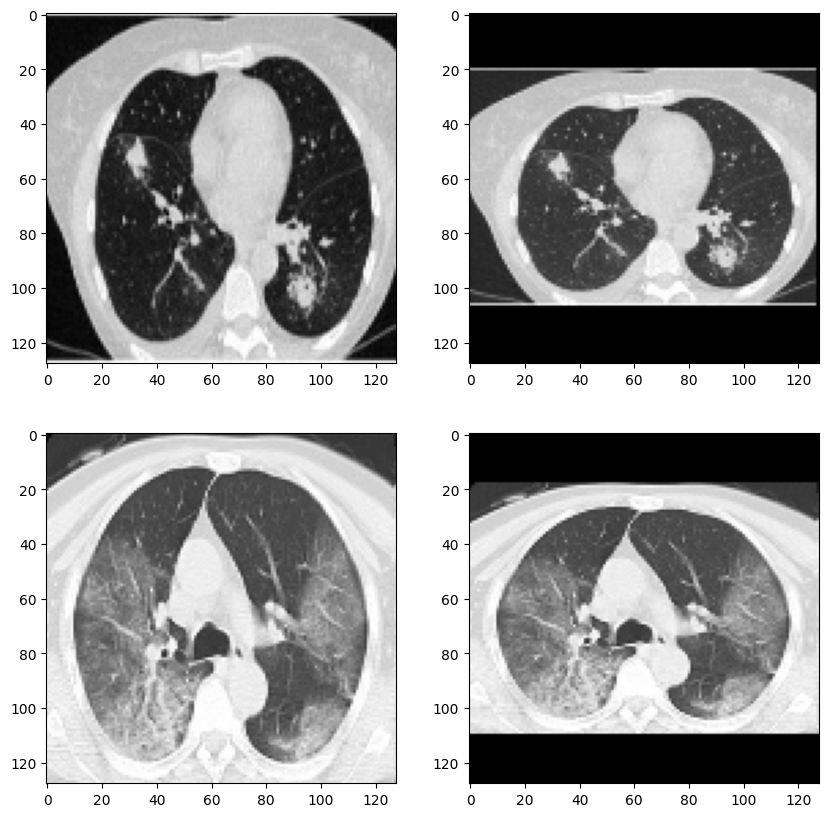

In [ ]:
#visualize the outputs of the two resizing functions
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for row in ax:
  index = np.random.randint(0, len(images))
  row[0].imshow(images[index][0, :, :], cmap='gray')
  row[1].imshow(images_padded[index][0, :, :], cmap='gray')

In [ ]:
# split the padded and non_padded datasets with the same indexes for comparability purposes
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42)
X_train_padded, X_test_padded, _, _ = train_test_split(images_padded, labels, test_size=0.20, random_state=42)
X_train_64, X_test_64, _, _ = train_test_split(images_64, labels, test_size=0.20, random_state=42)
X_train_padded_64, X_test_padded_64, _, _ = train_test_split(images_padded_64, labels, test_size=0.20, random_state=42)

# convert the lists into numpy arrays
X_train, X_test, y_train, y_test, X_train_padded, X_test_padded, X_train_64, X_test_64, X_train_padded_64, X_test_padded_64 = map(np.array, [X_train, X_test, y_train, y_test, X_train_padded, X_test_padded, X_train_64, X_test_64, X_train_padded_64, X_test_padded_64])

#Normalize both train datasets
scaler_ = StandardScaler()
scaler_pad = StandardScaler()
scaler64_pad = StandardScaler()
scaler64 = StandardScaler()

scaler_.fit(X_train.reshape(-1, X_train.shape[-1]))
scaler_pad.fit(X_train_padded.reshape(-1, X_train_padded.shape[-1]))
scaler64_pad.fit(X_train_padded_64.reshape(-1, X_train_padded_64.shape[-1]))
scaler64.fit(X_train_64.reshape(-1, X_train_64.shape[-1]))

def scale(scaler, array):
  return scaler.transform(array.reshape(-1, array.shape[-1])).reshape(array.shape)

X_train, X_test = scale(scaler_, X_train), scale(scaler_, X_test)
X_train_padded, X_test_padded = scale(scaler_pad, X_train_padded), scale(scaler_pad, X_test_padded)
X_train_64, X_test_64 = scale(scaler64, X_train_64), scale(scaler64, X_test_64)
X_train_padded_64, X_test_padded_64 = scale(scaler64_pad, X_train_padded_64), scale(scaler64_pad, X_test_padded_64)

## DataLoader objects

In [ ]:
def arrays_to_loader(X:np.array, #input data
                     y:np.array, # labels
                     shuffle:bool=True # don't shuffle the test set
                    ):
  set_ = TensorDataset(torch.from_numpy(X).type(torch.float32), torch.from_numpy(y).type(torch.float32))
  loader = DataLoader(set_, batch_size=batch_size, shuffle=shuffle)
  return loader

In [ ]:
#device-agnostic code for good practice
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_loader = arrays_to_loader(X_train, y_train)
test_loader = arrays_to_loader(X_test, y_test, False)
train_padded_loader = arrays_to_loader(X_train_padded, y_train)
test_padded_loader = arrays_to_loader(X_test_padded, y_test, False)
train_64_loader = arrays_to_loader(X_train_64, y_train)
test_64_loader = arrays_to_loader(X_test_64, y_test, False)
train_padded_64_loader = arrays_to_loader(X_train_padded_64, y_train)
test_padded_64_loader = arrays_to_loader(X_test_padded_64, y_test, False)

# Train and test loops

In [ ]:
#loss function for a binary classification task
loss_fn = nn.BCEWithLogitsLoss()
criterion = loss_fn

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               lr=0.01):
    ### Training
    model.train()
    train_loss, train_acc = 0, 0
    # Loop
    for X, y in dataloader:
        X, y = X.to(device), y.to(device).unsqueeze(1)

        # forward pass
        y_pred = model(X)

        # calculate loss
        loss = criterion(y_pred, y)
        train_loss += loss

        #
        y_pred_class = (y_pred >= 0.5).type(torch.float32)  # Apply threshold
        train_acc += torch.mean((y == y_pred_class).type(torch.float32))

        #
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

def test_step(model,
              dataloader,
              criterion: torch.nn.Module,
              device=device):
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    # TODO: Write here
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).unsqueeze(1)

            # forward pass
            y_pred = model(X)

            # calculate loss
            loss = criterion(y_pred, y)
            test_loss += loss

            #
            y_pred_class = (y_pred >= 0.5).type(torch.float32)
            test_acc += torch.mean((y == y_pred_class).type(torch.float32))

    #
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

def train(model,
          train_dataloader,
          test_dataloader,
          optimizer: torch.optim.Optimizer,
          epochs,
          device,
          lr=0.01):
    # Set the seed and start the timer
    torch.manual_seed(42)
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    # Create training and testing loop
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch+1} of {epochs}")

        ### Training
        train_loss, train_acc = train_step(model,
                                           train_dataloader,
                                           criterion,
                                           optimizer,
                                           device)

        ### Testing
        test_loss, test_acc = test_step(model,
                                        test_dataloader,
                                        criterion,
                                        device)

        # Update results dictionary
        results["train_loss"].append(train_loss.item())
        results["train_acc"].append(train_acc.item())
        results["test_loss"].append(test_loss.item())
        results["test_acc"].append(test_acc.item())

        # Print out what's happening
        print(f"Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}\n")
    return results


# Model Architectures
* Model 1: Six convolutional layers followed by a Fully connected layer
* Model 2: Same as Model 1 but with dropout layers added after each pooling layer
* Model 3: Same as Model 2 but with Batch Normalization layers added after each convolutional layer

## Model 1

In [ ]:
class CovidModelV1(nn.Module):
    def __init__(self, hidden_units: int = 32, dim: int = 128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_units, (3, 3))
        self.conv2 = nn.Conv2d(hidden_units, hidden_units, (3, 3))
        self.pool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(hidden_units, 2 * hidden_units, (3, 3))
        self.conv4 = nn.Conv2d(2 * hidden_units, 2 * hidden_units, (3, 3))
        self.conv5 = nn.Conv2d(2 * hidden_units, 4 * hidden_units, (3, 3))
        self.conv6 = nn.Conv2d(4 * hidden_units, 4 * hidden_units, (3, 3))
        self.fc = nn.LazyLinear(1)  # Output a single logit
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)

        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.pool(x)

        x = self.flatten(x)
        x = self.fc(x)
        return x

## Model 2


In [ ]:
class CovidModelV2(nn.Module):
    def __init__(self, hidden_units: int=32, dim:int=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_units, (3, 3))
        self.conv2 = nn.Conv2d(hidden_units, hidden_units, (3, 3))
        self.pool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(hidden_units, 2*hidden_units, (3, 3))
        self.conv4 = nn.Conv2d(2*hidden_units, 2*hidden_units, (3, 3))
        self.conv5 = nn.Conv2d(2*hidden_units, 4*hidden_units, (3, 3))
        self.conv6 = nn.Conv2d(4*hidden_units, 4*hidden_units, (3, 3))

        if dim == 128:
            fc_input_size = 12 * 12 * 4 * hidden_units  # Adjusted for 128x128 images
        elif dim == 64:
            fc_input_size = 6 * 6 * 4 * hidden_units   # Adjusted for 64x64 images
        else:
            raise ValueError("Unsupported dim value")

        self.fc = nn.LazyLinear(1)  # Output a single logit
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout=nn.Dropout2d(p=0.2)

    def forward(self, x:torch.Tensor):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)  # Apply dropout after pooling

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)  # Apply dropout after pooling

        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout(x)  # Apply dropout after pooling

        x = self.flatten(x)
        x = self.fc(x)
        return x

## Model 3

In [ ]:
class CovidModelV3(nn.Module):
    def __init__(self, hidden_units:int=32, dim:int=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, hidden_units, (3, 3))
        self.conv2 = nn.Conv2d(hidden_units, hidden_units, (3, 3))
        self.pool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(hidden_units, 2*hidden_units, (3, 3))
        self.conv4 = nn.Conv2d(2*hidden_units, 2*hidden_units, (3, 3))
        self.conv5 = nn.Conv2d(2*hidden_units, 4*hidden_units, (3, 3))
        self.conv6 = nn.Conv2d(4*hidden_units, 4*hidden_units, (3, 3))
        self.fc = nn.LazyLinear(1)  # Output a single logit
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout=nn.Dropout2d(p=0.2)
        self.batch_norm1 = nn.BatchNorm2d(hidden_units)
        self.batch_norm2 = nn.BatchNorm2d(hidden_units)
        self.batch_norm3 = nn.BatchNorm2d(2 * hidden_units)
        self.batch_norm4 = nn.BatchNorm2d(2 * hidden_units)
        self.batch_norm5 = nn.BatchNorm2d(4 * hidden_units)
        self.batch_norm6 = nn.BatchNorm2d(4 * hidden_units)

    def forward(self, x:torch.Tensor):
        x = self.relu(self.conv1(x))
        x = self.batch_norm1(x)  # Apply batch normalization
        x = self.relu(self.conv2(x))
        x = self.batch_norm2(x)  # Apply batch normalization
        x = self.pool(x)
        x = self.dropout(x)

        x = self.relu(self.conv3(x))
        x = self.batch_norm3(x)  # Apply batch normalization
        x = self.relu(self.conv4(x))
        x = self.batch_norm4(x)  # Apply batch normalization
        x = self.pool(x)
        x = self.dropout(x)

        x = self.relu(self.conv5(x))
        x = self.batch_norm5(x)  # Apply batch normalization
        x = self.relu(self.conv6(x))
        x = self.batch_norm6(x)  # Apply batch normalization
        x = self.pool(x)
        x = self.dropout(x)

        x = self.flatten(x)
        x = self.fc(x)
        return x

# Results

In [ ]:
epochs_=50
lr_ = 0.01
optimizer_class=torch.optim.SGD

## Functions

In [ ]:
def hyperparameter_tuning(model_class, optimizer_class):
  model_results={}

  model128 = model_class(32, 128).to(device)
  optimizer128 = optimizer_class(params=model128.parameters(), lr=0.03)
  model_results['no padding, 128*128']=train(model128, train_loader, test_loader, optimizer128, epochs_, device, lr_)

  model128p = model_class(32, 128).to(device)
  optimizer128p = optimizer_class(params=model128p.parameters(), lr=0.03)
  model_results['padding, 128*128']=train(model128p, train_padded_loader, test_padded_loader, optimizer128p, epochs_, device, lr_)

  model64 = model_class(32, 64).to(device)
  optimizer64 = optimizer_class(params=model64.parameters(), lr=0.03)
  model_results['no padding, 64*64']=train(model64, train_64_loader, test_64_loader, optimizer64, epochs_, device, lr_)

  model64p = model_class(32, 64).to(device)
  optimizer64p = optimizer_class(params=model64p.parameters(), lr=0.03)
  model_results['padding, 64*64']=train(model64p, train_padded_64_loader, test_padded_64_loader, optimizer64p, epochs_, device, lr_)

  return model_results

In [ ]:
def get_best_results(model_results):
    best_results = []

    for model_key, metrics in model_results.items():
        test_acc_values = metrics['test_acc']
        best_epoch = test_acc_values.index(max(test_acc_values)) + 1
        train_acc = metrics['train_acc'][best_epoch - 1]
        test_acc = max(test_acc_values)

        best_results.append([train_acc, test_acc])

    index_names = ['no padding, 128*128', 'padding, 128*128', 'no padding, 64*64', 'padding, 64*64']
    columns = ['Train Accuracy', 'Test Accuracy']
    df = pd.DataFrame(best_results, index=index_names, columns=columns)

    return df


In [ ]:
def visualize_accuracy(model_results):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()

    index_names = ['no padding, 128*128', 'padding, 128*128', 'no padding, 64*64', 'padding, 64*64']

    for i, (model_key, metrics) in enumerate(model_results.items()):
        train_acc_values = metrics['train_acc']
        test_acc_values = metrics['test_acc']
        epochs = list(range(1, len(train_acc_values) + 1))

        ax = axs[i]
        ax.plot(epochs, train_acc_values, label='Train Accuracy', linestyle='--')
        ax.plot(epochs, test_acc_values, label='Test Accuracy', linewidth=2)
        ax.set_title(model_key)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        ax.legend()

    plt.tight_layout()
    plt.show()


## Model 1

In [ ]:
Model1 = hyperparameter_tuning(CovidModelV1, optimizer_class)
Model1_best = get_best_results(Model1)
Model1_best

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 0.69211, Train acc: 0.54 | Test loss: 0.68920, Test acc: 0.53

Epoch: 2 of 50
Train loss: 0.69031, Train acc: 0.53 | Test loss: 0.68663, Test acc: 0.53

Epoch: 3 of 50
Train loss: 0.68775, Train acc: 0.53 | Test loss: 0.68248, Test acc: 0.53

Epoch: 4 of 50
Train loss: 0.68090, Train acc: 0.53 | Test loss: 0.67317, Test acc: 0.53

Epoch: 5 of 50
Train loss: 0.66709, Train acc: 0.53 | Test loss: 0.65711, Test acc: 0.55

Epoch: 6 of 50
Train loss: 0.63630, Train acc: 0.59 | Test loss: 0.62123, Test acc: 0.62

Epoch: 7 of 50
Train loss: 0.64020, Train acc: 0.59 | Test loss: 0.66322, Test acc: 0.54

Epoch: 8 of 50
Train loss: 0.61050, Train acc: 0.62 | Test loss: 0.92493, Test acc: 0.56

Epoch: 9 of 50
Train loss: 0.59422, Train acc: 0.65 | Test loss: 0.81124, Test acc: 0.59

Epoch: 10 of 50
Train loss: 0.57279, Train acc: 0.68 | Test loss: 0.59320, Test acc: 0.64

Epoch: 11 of 50
Train loss: 0.54858, Train acc: 0.72 | Test loss: 0.62468, Test acc: 0.73

Epoch: 1

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 0.69352, Train acc: 0.54 | Test loss: 0.69093, Test acc: 0.53

Epoch: 2 of 50
Train loss: 0.69246, Train acc: 0.53 | Test loss: 0.69011, Test acc: 0.53

Epoch: 3 of 50
Train loss: 0.69190, Train acc: 0.53 | Test loss: 0.68919, Test acc: 0.53

Epoch: 4 of 50
Train loss: 0.68973, Train acc: 0.53 | Test loss: 0.68715, Test acc: 0.53

Epoch: 5 of 50
Train loss: 0.68838, Train acc: 0.53 | Test loss: 0.68388, Test acc: 0.53

Epoch: 6 of 50
Train loss: 0.68308, Train acc: 0.53 | Test loss: 0.67577, Test acc: 0.53

Epoch: 7 of 50
Train loss: 0.68230, Train acc: 0.53 | Test loss: 0.66946, Test acc: 0.53

Epoch: 8 of 50
Train loss: 0.67596, Train acc: 0.54 | Test loss: 0.71252, Test acc: 0.53

Epoch: 9 of 50
Train loss: 0.66428, Train acc: 0.54 | Test loss: 0.74552, Test acc: 0.55

Epoch: 10 of 50
Train loss: 0.65696, Train acc: 0.54 | Test loss: 0.66012, Test acc: 0.64

Epoch: 11 of 50
Train loss: 0.65163, Train acc: 0.56 | Test loss: 0.78234, Test acc: 0.56

Epoch: 1

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 0.69281, Train acc: 0.54 | Test loss: 0.69121, Test acc: 0.53

Epoch: 2 of 50
Train loss: 0.69154, Train acc: 0.53 | Test loss: 0.69052, Test acc: 0.53

Epoch: 3 of 50
Train loss: 0.69159, Train acc: 0.53 | Test loss: 0.69005, Test acc: 0.53

Epoch: 4 of 50
Train loss: 0.69054, Train acc: 0.53 | Test loss: 0.68936, Test acc: 0.53

Epoch: 5 of 50
Train loss: 0.69027, Train acc: 0.53 | Test loss: 0.68806, Test acc: 0.53

Epoch: 6 of 50
Train loss: 0.68788, Train acc: 0.53 | Test loss: 0.68554, Test acc: 0.53

Epoch: 7 of 50
Train loss: 0.68694, Train acc: 0.53 | Test loss: 0.68243, Test acc: 0.53

Epoch: 8 of 50
Train loss: 0.68097, Train acc: 0.54 | Test loss: 0.68392, Test acc: 0.53

Epoch: 9 of 50
Train loss: 0.67795, Train acc: 0.53 | Test loss: 0.68156, Test acc: 0.53

Epoch: 10 of 50
Train loss: 0.66875, Train acc: 0.53 | Test loss: 0.66472, Test acc: 0.53

Epoch: 11 of 50
Train loss: 0.66882, Train acc: 0.53 | Test loss: 0.66895, Test acc: 0.54

Epoch: 1

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 0.69315, Train acc: 0.54 | Test loss: 0.69179, Test acc: 0.53

Epoch: 2 of 50
Train loss: 0.69208, Train acc: 0.53 | Test loss: 0.69136, Test acc: 0.53

Epoch: 3 of 50
Train loss: 0.69221, Train acc: 0.53 | Test loss: 0.69117, Test acc: 0.53

Epoch: 4 of 50
Train loss: 0.69148, Train acc: 0.53 | Test loss: 0.69094, Test acc: 0.53

Epoch: 5 of 50
Train loss: 0.69179, Train acc: 0.53 | Test loss: 0.69064, Test acc: 0.53

Epoch: 6 of 50
Train loss: 0.69078, Train acc: 0.53 | Test loss: 0.69024, Test acc: 0.53

Epoch: 7 of 50
Train loss: 0.69080, Train acc: 0.53 | Test loss: 0.68971, Test acc: 0.53

Epoch: 8 of 50
Train loss: 0.68917, Train acc: 0.54 | Test loss: 0.68941, Test acc: 0.53

Epoch: 9 of 50
Train loss: 0.68933, Train acc: 0.53 | Test loss: 0.68802, Test acc: 0.53

Epoch: 10 of 50
Train loss: 0.68736, Train acc: 0.53 | Test loss: 0.68521, Test acc: 0.53

Epoch: 11 of 50
Train loss: 0.68598, Train acc: 0.53 | Test loss: 0.68377, Test acc: 0.53

Epoch: 1

,Train Accuracy,Test Accuracy
"no padding, 128*128",0.929276,0.783333
"padding, 128*128",0.868421,0.758333
"no padding, 64*64",0.888158,0.733333
"padding, 64*64",0.797697,0.727083


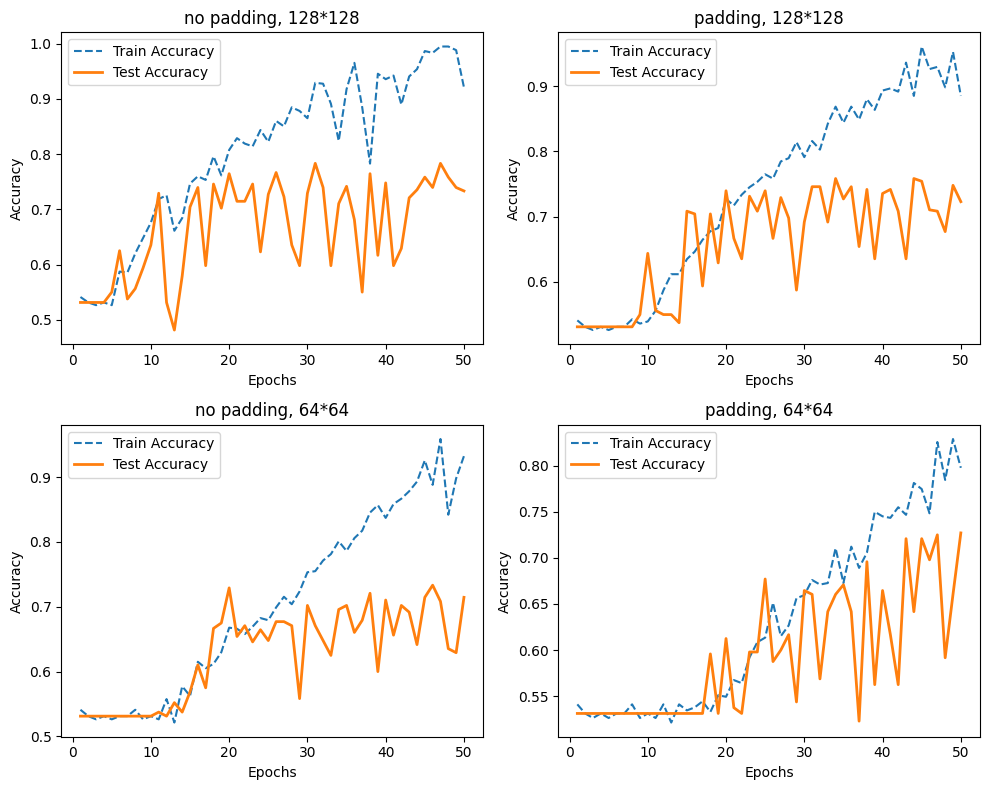

In [ ]:
visualize_accuracy(Model1)

## Model 2

In [ ]:
Model2 = hyperparameter_tuning(CovidModelV2, optimizer_class)
Model2_best = get_best_results(Model2)
Model2_best

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 0.69298, Train acc: 0.54 | Test loss: 0.69005, Test acc: 0.53

Epoch: 2 of 50
Train loss: 0.69172, Train acc: 0.53 | Test loss: 0.68869, Test acc: 0.53

Epoch: 3 of 50
Train loss: 0.68994, Train acc: 0.53 | Test loss: 0.68583, Test acc: 0.53

Epoch: 4 of 50
Train loss: 0.68684, Train acc: 0.53 | Test loss: 0.68058, Test acc: 0.53

Epoch: 5 of 50
Train loss: 0.67663, Train acc: 0.53 | Test loss: 0.66545, Test acc: 0.53

Epoch: 6 of 50
Train loss: 0.66605, Train acc: 0.54 | Test loss: 0.65023, Test acc: 0.56

Epoch: 7 of 50
Train loss: 0.66185, Train acc: 0.56 | Test loss: 0.63483, Test acc: 0.55

Epoch: 8 of 50
Train loss: 0.63616, Train acc: 0.59 | Test loss: 0.89246, Test acc: 0.53

Epoch: 9 of 50
Train loss: 0.63336, Train acc: 0.62 | Test loss: 0.70202, Test acc: 0.66

Epoch: 10 of 50
Train loss: 0.60138, Train acc: 0.64 | Test loss: 0.58884, Test acc: 0.65

Epoch: 11 of 50
Train loss: 0.61142, Train acc: 0.63 | Test loss: 0.69764, Test acc: 0.70

Epoch: 1

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 0.69354, Train acc: 0.54 | Test loss: 0.69078, Test acc: 0.53

Epoch: 2 of 50
Train loss: 0.69253, Train acc: 0.53 | Test loss: 0.69026, Test acc: 0.53

Epoch: 3 of 50
Train loss: 0.69185, Train acc: 0.53 | Test loss: 0.68904, Test acc: 0.53

Epoch: 4 of 50
Train loss: 0.69031, Train acc: 0.53 | Test loss: 0.68747, Test acc: 0.53

Epoch: 5 of 50
Train loss: 0.68930, Train acc: 0.53 | Test loss: 0.68402, Test acc: 0.53

Epoch: 6 of 50
Train loss: 0.68558, Train acc: 0.53 | Test loss: 0.68063, Test acc: 0.53

Epoch: 7 of 50
Train loss: 0.68534, Train acc: 0.53 | Test loss: 0.67252, Test acc: 0.53

Epoch: 8 of 50
Train loss: 0.68125, Train acc: 0.54 | Test loss: 0.70378, Test acc: 0.53

Epoch: 9 of 50
Train loss: 0.68073, Train acc: 0.53 | Test loss: 0.69464, Test acc: 0.66

Epoch: 10 of 50
Train loss: 0.66247, Train acc: 0.55 | Test loss: 0.68534, Test acc: 0.64

Epoch: 11 of 50
Train loss: 0.67636, Train acc: 0.52 | Test loss: 0.72237, Test acc: 0.61

Epoch: 1

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 0.69199, Train acc: 0.54 | Test loss: 0.69109, Test acc: 0.53

Epoch: 2 of 50
Train loss: 0.69133, Train acc: 0.53 | Test loss: 0.69044, Test acc: 0.53

Epoch: 3 of 50
Train loss: 0.69161, Train acc: 0.53 | Test loss: 0.68988, Test acc: 0.53

Epoch: 4 of 50
Train loss: 0.69017, Train acc: 0.53 | Test loss: 0.68866, Test acc: 0.53

Epoch: 5 of 50
Train loss: 0.68820, Train acc: 0.53 | Test loss: 0.68548, Test acc: 0.53

Epoch: 6 of 50
Train loss: 0.68760, Train acc: 0.53 | Test loss: 0.68289, Test acc: 0.53

Epoch: 7 of 50
Train loss: 0.68653, Train acc: 0.53 | Test loss: 0.68173, Test acc: 0.53

Epoch: 8 of 50
Train loss: 0.67800, Train acc: 0.54 | Test loss: 0.68173, Test acc: 0.53

Epoch: 9 of 50
Train loss: 0.68259, Train acc: 0.53 | Test loss: 0.68163, Test acc: 0.53

Epoch: 10 of 50
Train loss: 0.68222, Train acc: 0.53 | Test loss: 0.67099, Test acc: 0.53

Epoch: 11 of 50
Train loss: 0.67497, Train acc: 0.53 | Test loss: 0.67440, Test acc: 0.53

Epoch: 1

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 0.69230, Train acc: 0.54 | Test loss: 0.69147, Test acc: 0.53

Epoch: 2 of 50
Train loss: 0.69191, Train acc: 0.53 | Test loss: 0.69119, Test acc: 0.53

Epoch: 3 of 50
Train loss: 0.69227, Train acc: 0.53 | Test loss: 0.69111, Test acc: 0.53

Epoch: 4 of 50
Train loss: 0.69162, Train acc: 0.53 | Test loss: 0.69092, Test acc: 0.53

Epoch: 5 of 50
Train loss: 0.69168, Train acc: 0.53 | Test loss: 0.69071, Test acc: 0.53

Epoch: 6 of 50
Train loss: 0.69123, Train acc: 0.53 | Test loss: 0.69053, Test acc: 0.53

Epoch: 7 of 50
Train loss: 0.69104, Train acc: 0.53 | Test loss: 0.69027, Test acc: 0.53

Epoch: 8 of 50
Train loss: 0.69001, Train acc: 0.54 | Test loss: 0.69012, Test acc: 0.53

Epoch: 9 of 50
Train loss: 0.69129, Train acc: 0.53 | Test loss: 0.68969, Test acc: 0.53

Epoch: 10 of 50
Train loss: 0.68943, Train acc: 0.53 | Test loss: 0.68881, Test acc: 0.53

Epoch: 11 of 50
Train loss: 0.69031, Train acc: 0.53 | Test loss: 0.68786, Test acc: 0.53

Epoch: 1

,Train Accuracy,Test Accuracy
"no padding, 128*128",0.894737,0.802083
"padding, 128*128",0.751645,0.758333
"no padding, 64*64",0.805921,0.714583
"padding, 64*64",0.664474,0.733333


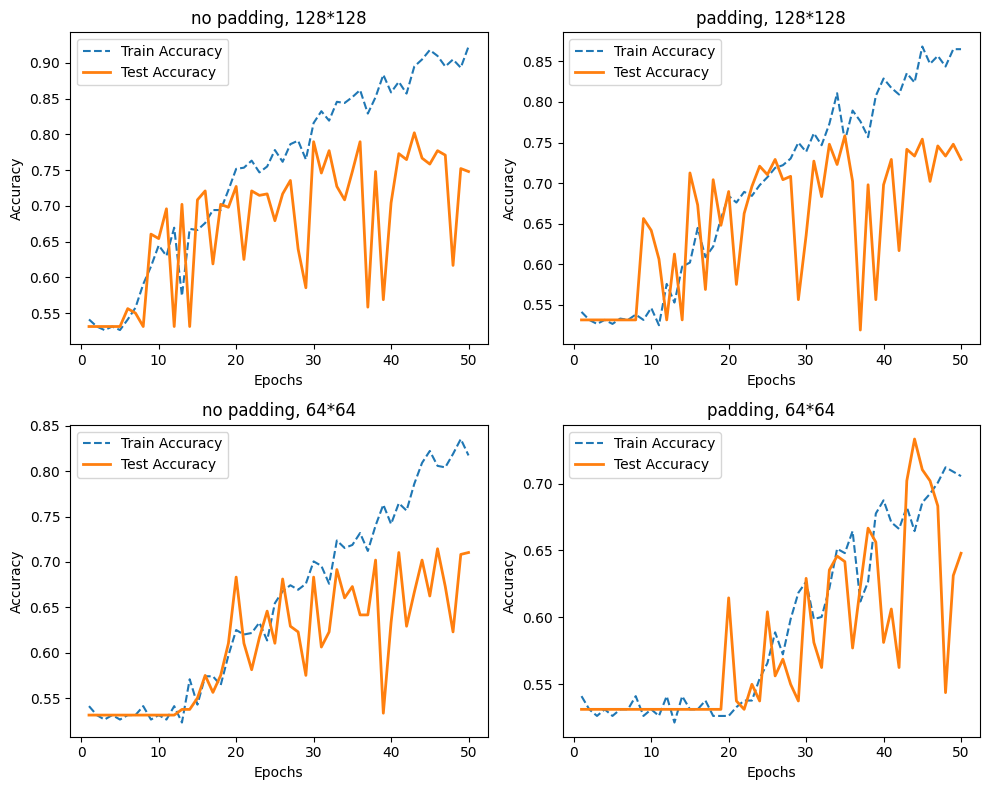

In [ ]:
visualize_accuracy(Model2)

## Model 3

In [ ]:
Model3 = hyperparameter_tuning(CovidModelV3, optimizer_class)
Model3_best = get_best_results(Model3)
Model3_best

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 11.36704, Train acc: 0.59 | Test loss: 17.03370, Test acc: 0.56

Epoch: 2 of 50
Train loss: 6.54711, Train acc: 0.61 | Test loss: 4.66897, Test acc: 0.72

Epoch: 3 of 50
Train loss: 4.75289, Train acc: 0.68 | Test loss: 8.10029, Test acc: 0.58

Epoch: 4 of 50
Train loss: 3.79223, Train acc: 0.69 | Test loss: 2.36217, Test acc: 0.71

Epoch: 5 of 50
Train loss: 3.56178, Train acc: 0.72 | Test loss: 9.24242, Test acc: 0.68

Epoch: 6 of 50
Train loss: 2.74855, Train acc: 0.71 | Test loss: 2.46185, Test acc: 0.76

Epoch: 7 of 50
Train loss: 2.45593, Train acc: 0.75 | Test loss: 3.57491, Test acc: 0.72

Epoch: 8 of 50
Train loss: 2.29677, Train acc: 0.74 | Test loss: 3.98654, Test acc: 0.60

Epoch: 9 of 50
Train loss: 1.97056, Train acc: 0.77 | Test loss: 2.60734, Test acc: 0.70

Epoch: 10 of 50
Train loss: 1.62463, Train acc: 0.76 | Test loss: 1.67009, Test acc: 0.75

Epoch: 11 of 50
Train loss: 1.14233, Train acc: 0.78 | Test loss: 1.65940, Test acc: 0.78

Epoch:

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 15.84724, Train acc: 0.57 | Test loss: 10.14934, Test acc: 0.56

Epoch: 2 of 50
Train loss: 8.23948, Train acc: 0.61 | Test loss: 14.28935, Test acc: 0.60

Epoch: 3 of 50
Train loss: 6.27734, Train acc: 0.66 | Test loss: 4.23624, Test acc: 0.63

Epoch: 4 of 50
Train loss: 4.49161, Train acc: 0.64 | Test loss: 7.42919, Test acc: 0.63

Epoch: 5 of 50
Train loss: 2.92836, Train acc: 0.69 | Test loss: 6.52296, Test acc: 0.61

Epoch: 6 of 50
Train loss: 2.46793, Train acc: 0.71 | Test loss: 3.19506, Test acc: 0.64

Epoch: 7 of 50
Train loss: 1.68047, Train acc: 0.73 | Test loss: 1.58562, Test acc: 0.73

Epoch: 8 of 50
Train loss: 1.81833, Train acc: 0.73 | Test loss: 3.57535, Test acc: 0.64

Epoch: 9 of 50
Train loss: 1.35729, Train acc: 0.75 | Test loss: 3.93122, Test acc: 0.64

Epoch: 10 of 50
Train loss: 1.26190, Train acc: 0.76 | Test loss: 1.18101, Test acc: 0.77

Epoch: 11 of 50
Train loss: 1.30734, Train acc: 0.78 | Test loss: 1.17637, Test acc: 0.75

Epoch

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 1.79480, Train acc: 0.57 | Test loss: 2.95983, Test acc: 0.62

Epoch: 2 of 50
Train loss: 1.79034, Train acc: 0.58 | Test loss: 4.22679, Test acc: 0.60

Epoch: 3 of 50
Train loss: 1.31435, Train acc: 0.66 | Test loss: 1.45758, Test acc: 0.67

Epoch: 4 of 50
Train loss: 1.20874, Train acc: 0.66 | Test loss: 1.70681, Test acc: 0.63

Epoch: 5 of 50
Train loss: 1.13354, Train acc: 0.68 | Test loss: 1.30147, Test acc: 0.59

Epoch: 6 of 50
Train loss: 1.12157, Train acc: 0.68 | Test loss: 1.86087, Test acc: 0.71

Epoch: 7 of 50
Train loss: 1.31683, Train acc: 0.66 | Test loss: 0.72500, Test acc: 0.72

Epoch: 8 of 50
Train loss: 0.82040, Train acc: 0.72 | Test loss: 1.40828, Test acc: 0.66

Epoch: 9 of 50
Train loss: 0.95010, Train acc: 0.72 | Test loss: 2.77285, Test acc: 0.70

Epoch: 10 of 50
Train loss: 0.97023, Train acc: 0.71 | Test loss: 0.87216, Test acc: 0.70

Epoch: 11 of 50
Train loss: 0.91044, Train acc: 0.72 | Test loss: 1.31656, Test acc: 0.61

Epoch: 1

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 of 50
Train loss: 1.66402, Train acc: 0.58 | Test loss: 2.33700, Test acc: 0.54

Epoch: 2 of 50
Train loss: 1.02117, Train acc: 0.64 | Test loss: 1.15794, Test acc: 0.65

Epoch: 3 of 50
Train loss: 0.79420, Train acc: 0.66 | Test loss: 0.59708, Test acc: 0.71

Epoch: 4 of 50
Train loss: 0.77844, Train acc: 0.66 | Test loss: 0.79628, Test acc: 0.71

Epoch: 5 of 50
Train loss: 0.66203, Train acc: 0.71 | Test loss: 0.61025, Test acc: 0.72

Epoch: 6 of 50
Train loss: 0.60820, Train acc: 0.73 | Test loss: 0.55069, Test acc: 0.77

Epoch: 7 of 50
Train loss: 0.54435, Train acc: 0.77 | Test loss: 0.54964, Test acc: 0.74

Epoch: 8 of 50
Train loss: 0.49532, Train acc: 0.76 | Test loss: 1.01263, Test acc: 0.55

Epoch: 9 of 50
Train loss: 0.48559, Train acc: 0.77 | Test loss: 0.83282, Test acc: 0.72

Epoch: 10 of 50
Train loss: 0.40937, Train acc: 0.81 | Test loss: 0.55742, Test acc: 0.75

Epoch: 11 of 50
Train loss: 0.52992, Train acc: 0.76 | Test loss: 0.83538, Test acc: 0.71

Epoch: 1

,Train Accuracy,Test Accuracy
"no padding, 128*128",0.856908,0.808333
"padding, 128*128",0.865132,0.843750
"no padding, 64*64",0.970395,0.818750
"padding, 64*64",0.968750,0.839583


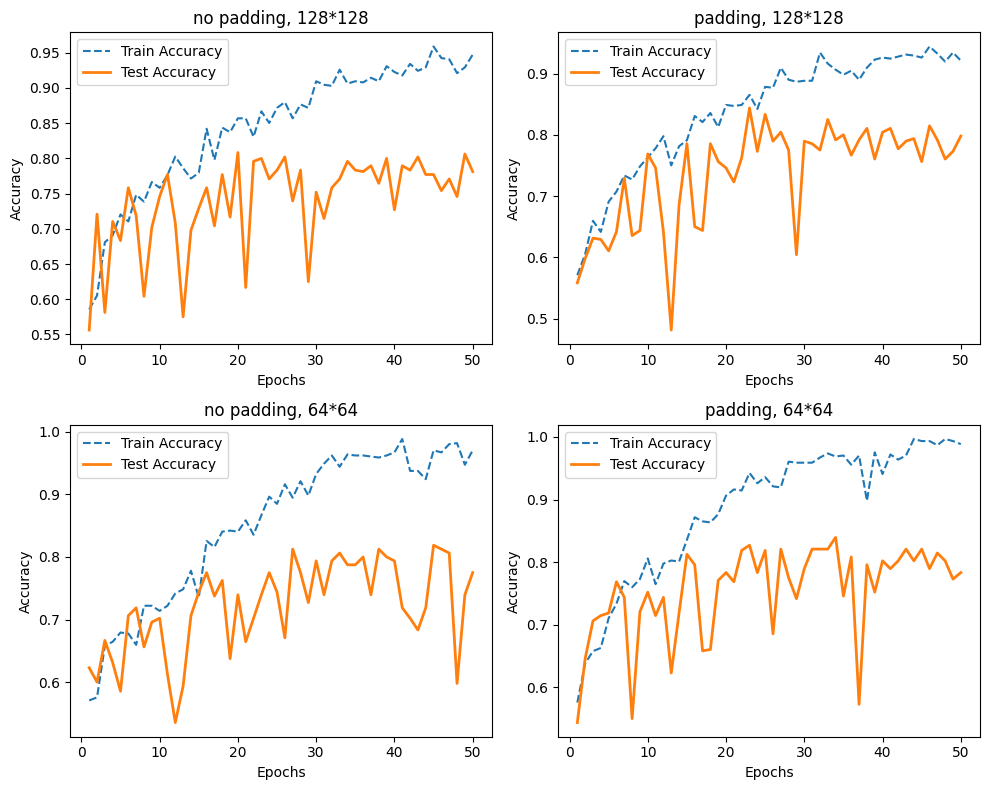

In [ ]:
visualize_accuracy(Model3)

# Conclusion
* Dropout and batch normalization improved the test accuracy metric overally.
* The difference between padding vs. no padding was inconsistent.
Models 1 & 2 achieved their best test accuracy with the 'padding, dim=128' hyperparameters, while Model 3 achieved its best test accuracy with the 'padding, dim=128 hyperparameters'
* Probably just some random observation. More data is needed to conclude about padding vs. no padding